# Assignment 1 — Netflix Titles Analysis

**Name:** Aleena Tomy  
**Course:** CS 4379G — Data Analysis & Visualization

---

**Research questions:**
1. How has the number of titles added to Netflix changed over time (by year)?
2. Do Movies and TV Shows differ in typical duration or in ratings distribution?

## 1) Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

SEED = 42
rng = np.random.default_rng(SEED)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

## 2) Load data

In [2]:
CSV_PATH = Path("netflix_titles.csv")

if not CSV_PATH.exists():
    raise FileNotFoundError(
        f"Missing {CSV_PATH}. "
        "Download from Kaggle and place in the same folder as this notebook."
    )

df = pd.read_csv(CSV_PATH)
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Data dictionary

| Column | What it is |
|---|---|
| `show_id` | Unique ID for each title |
| `type` | Movie or TV Show |
| `title` | Name of the title |
| `director` | Director(s), sometimes missing |
| `cast` | Cast members, sometimes missing |
| `country` | Country/countries of production |
| `date_added` | Date added to Netflix |
| `release_year` | Original release year |
| `rating` | Content rating (TV-MA, PG-13, etc.) |
| `duration` | Minutes for movies, seasons for TV shows |
| `listed_in` | Genre categories |
| `description` | Short description |

## 3) Quick checks

In [3]:
df.shape

(8807, 12)

In [4]:
df.columns.tolist()

['show_id',
 'type',
 'title',
 'director',
 'cast',
 'country',
 'date_added',
 'release_year',
 'rating',
 'duration',
 'listed_in',
 'description']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [6]:
df.isna().sum().sort_values(ascending=False)

director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
listed_in          0
description        0
dtype: int64

In [7]:
# check for duplicates
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


## 4) Data cleaning

- Parse `date_added` and create `year_added`
- Pull out the number from `duration` so we can do math with it
- Handle missing values as needed

In [8]:
# parse date_added
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
df["year_added"] = df["date_added"].dt.year

df[["title", "type", "date_added", "year_added"]].head(10)

,title,type,date_added,year_added
0,Dick Johnson Is Dead,Movie,2021-09-25,2021.0
1,Blood & Water,TV Show,2021-09-24,2021.0
2,Ganglands,TV Show,2021-09-24,2021.0
3,Jailbirds New Orleans,TV Show,2021-09-24,2021.0
4,Kota Factory,TV Show,2021-09-24,2021.0
5,Midnight Mass,TV Show,2021-09-24,2021.0
6,My Little Pony: A New Generation,Movie,2021-09-24,2021.0
7,Sankofa,Movie,2021-09-24,2021.0
8,The Great British Baking Show,TV Show,2021-09-24,2021.0
9,The Starling,Movie,2021-09-24,2021.0


In [9]:
def extract_duration_number(duration_str):
    """
    Pull out the number from the duration column.
    e.g. '90 min' -> 90, '2 Seasons' -> 2
    Returns NaN if it can't parse.
    """
    if pd.isna(duration_str):
        return np.nan
    parts = str(duration_str).strip().split()
    try:
        return int(parts[0])
    except (ValueError, IndexError):
        return np.nan

In [10]:
df["duration_num"] = df["duration"].apply(extract_duration_number)

# sanity check
print("Movies (minutes):")
print(df.loc[df["type"] == "Movie", "duration_num"].describe())
print()
print("TV Shows (seasons):")
print(df.loc[df["type"] == "TV Show", "duration_num"].describe())

Movies (minutes):
count    6128.000000
mean       99.577187
std        28.290593
min         3.000000
25%        87.000000
50%        98.000000
75%       114.000000
max       312.000000
Name: duration_num, dtype: float64

TV Shows (seasons):
count    2676.000000
mean        1.764948
std         1.582752
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: duration_num, dtype: float64


## 5) Analysis

### Q1) How has the number of titles added changed over time?

In [11]:
# titles added per year, split by type
df_year = df.dropna(subset=["year_added"]).copy()
df_year["year_added"] = df_year["year_added"].astype(int)

added_by_year = df_year.groupby(["year_added", "type"]).size().unstack(fill_value=0)
added_by_year

type,Movie,TV Show
year_added,,
2008,1,1
2009,2,0
2010,1,0
2011,13,0
2012,3,0
2013,6,4
2014,19,4
2015,56,17
2016,253,165


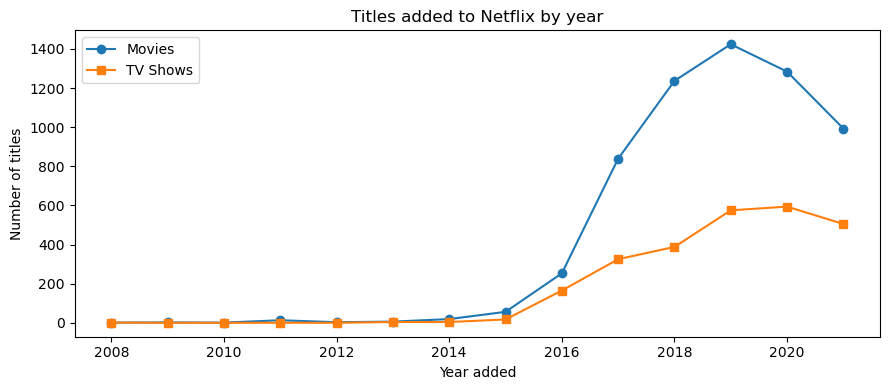

In [12]:
plt.figure(figsize=(9, 4))
plt.plot(added_by_year.index, added_by_year["Movie"], marker="o", label="Movies")
plt.plot(added_by_year.index, added_by_year["TV Show"], marker="s", label="TV Shows")
plt.xlabel("Year added")
plt.ylabel("Number of titles")
plt.title("Titles added to Netflix by year")
plt.legend()
plt.tight_layout()
plt.show()

Netflix added very few titles before 2015, then ramped up fast and peaked around 2019. After that there's a drop — could be because of licensing changes or the dataset not fully covering 2021. Movies are always more than TV shows but the gap has been shrinking as Netflix invested more in series.

### Q2) Movies vs TV Shows — duration and ratings

In [13]:
movies = df[df["type"] == "Movie"]
tv_shows = df[df["type"] == "TV Show"]

print(f"Movies: {len(movies)}, TV Shows: {len(tv_shows)}")
print(f"Movie duration median: {movies['duration_num'].median():.0f} min")
print(f"TV Show seasons median: {tv_shows['duration_num'].median():.0f}")

Movies: 6131, TV Shows: 2676
Movie duration median: 98 min
TV Show seasons median: 1


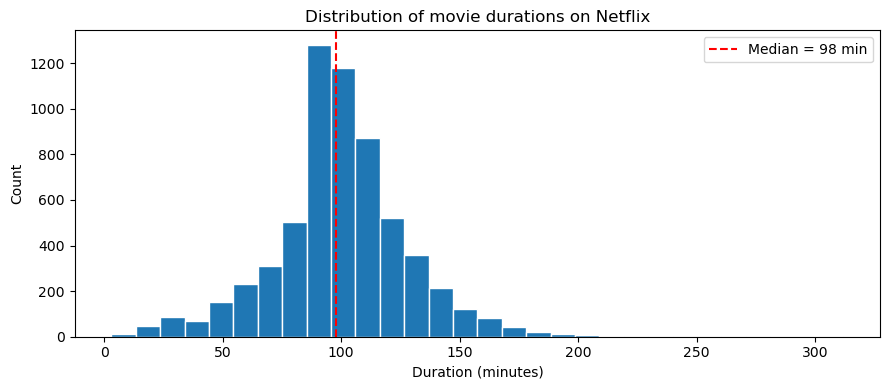

In [14]:
# distribution of movie durations
plt.figure(figsize=(9, 4))
plt.hist(movies["duration_num"].dropna(), bins=30, edgecolor="white")
plt.axvline(movies["duration_num"].median(), color="red", linestyle="--",
            label=f"Median = {movies['duration_num'].median():.0f} min")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.title("Distribution of movie durations on Netflix")
plt.legend()
plt.tight_layout()
plt.show()

Most movies cluster around 90–100 minutes which is pretty standard for feature films. There's a small spike of really short ones (under ~30 min) that are probably stand-up specials or short films, and a few outliers over 150 minutes.

In [15]:
def rating_counts_for(dataframe, content_type):
    """
    Get rating value counts for a given type (Movie or TV Show).
    """
    subset = dataframe[dataframe["type"] == content_type]
    return subset["rating"].value_counts()

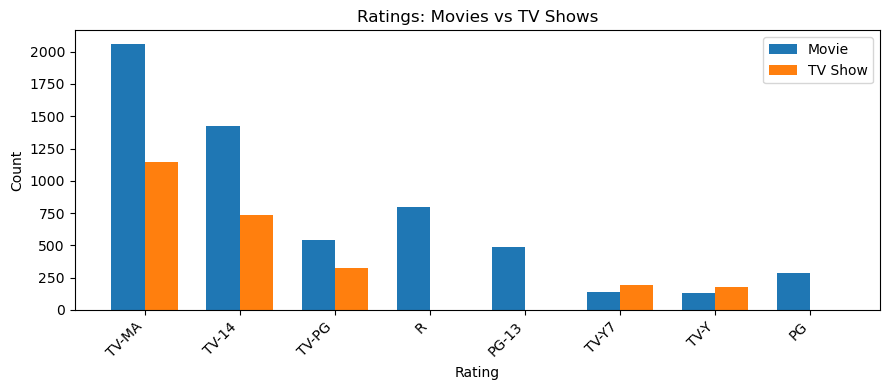

In [16]:
# compare ratings — use top 8 so the chart isn't too crowded
top_ratings = df["rating"].value_counts().head(8).index.tolist()

m_ratings = rating_counts_for(df, "Movie")
t_ratings = rating_counts_for(df, "TV Show")

movie_vals = [m_ratings.get(r, 0) for r in top_ratings]
tv_vals = [t_ratings.get(r, 0) for r in top_ratings]

x = np.arange(len(top_ratings))
width = 0.35

plt.figure(figsize=(9, 4))
plt.bar(x - width/2, movie_vals, width, label="Movie")
plt.bar(x + width/2, tv_vals, width, label="TV Show")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Ratings: Movies vs TV Shows")
plt.xticks(x, top_ratings, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

TV-MA is the most common rating for both types but it really dominates for TV Shows. Movies are more spread out across TV-14, TV-PG, R, and PG-13. So it looks like Netflix's TV content skews more toward mature audiences while the movie catalog covers a wider range of ratings.

## 6) Interpretation

- Netflix's catalog grew a lot between 2015–2019 then slowed down, probably because of the shift toward originals and losing licensed content to other streaming platforms.
- Movies make up about 70% of the catalog but TV Show additions have been catching up over the years.
- The typical movie is around 98 minutes. Most TV shows are single-season which could mean they're new shows or ones that didn't get renewed.
- TV Shows lean more toward mature ratings (TV-MA) while Movies have a broader range.

## 7) Reproducibility check

Run **Kernel → Restart & Run All** before submitting.

In [17]:
print("If you reached this cell after Restart & Run All, the notebook is reproducible.")

If you reached this cell after Restart & Run All, the notebook is reproducible.
